1. Kompresja obrazów z użyciem sieci neuronowej  

·         Zbiór danych Fashion-MNIST X

·         Budujemy sieć neuronową dla kompresji danych, a następnie próbujemy sprawdzić czy sieć jest wstanie rozpoznać (poprawnie skwalifikować) dane z dekodera. Proszę również pokazać że sieć do kompresji można „rozciąć” na układ koder-dekoder. X

Tworzymy auto-enkoder i w pierwszej kolejności chcemy pokazać zależność błędu pomiędzy wyjściem a wejściem w stosunku do stopnia kompresji,

Następnie patrzymy dla jakiś sensownych – wybranych - punktów z powyższej krzywej jak wygląda klasyfikacja danych zakodowanych.        Dla każdego wyniku stosujemy różne miary błędu (ewaluacji) MSE, macierz pomyłek, krzywe ROC, specyficzność czułość, pole pod ROC itp.  

·         Wyniki proszę porównać z istniejącymi w literaturze.  

# Implementacja trzech auto-enkoderów

1. dodać metryki,
2. sprawdzić zapis modeli i histori
3. layout zestawień + samplowanie przykładów z zebioru testowego
4. aktualizacja callbacku

In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.layers import *
from keras.models import Model, load_model
from keras.datasets import mnist
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras import regularizers
from keras import optimizers
from keras import backend as K
import os
import csv
import random
import scipy
import matplotlib.pyplot as plt
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import math
from google.colab import drive

drive.mount('/content/drive')

!mkdir -p "/content/drive/My Drive/SSN Projekt"
!mkdir -p "/content/drive/My Drive/SSN Projekt/Double_MaxPooling2D"
!mkdir -p "/content/drive/My Drive/SSN Projekt/MaxPooling2D"
!mkdir -p "/content/drive/My Drive/SSN Projekt/Dense"
!mkdir -p "/content/drive/My Drive/SSN Projekt/Conv2D"

Mounted at /content/drive


In [ ]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

# Normalizacja danych
x_train = x_train.reshape(-1, 28, 28) / 255.0
x_test = x_test.reshape(-1, 28, 28) / 255.0

# Podział zbioru danych uczących na mniejszy zbiór
# x_train, _, y_train_small, _ = train_test_split(x_train, y_train, train_size=0.01, random_state=42)

folder_base = "/content/drive/My Drive/SSN Projekt/"

4422102/4422102 [==============================] - 1s 0us/step


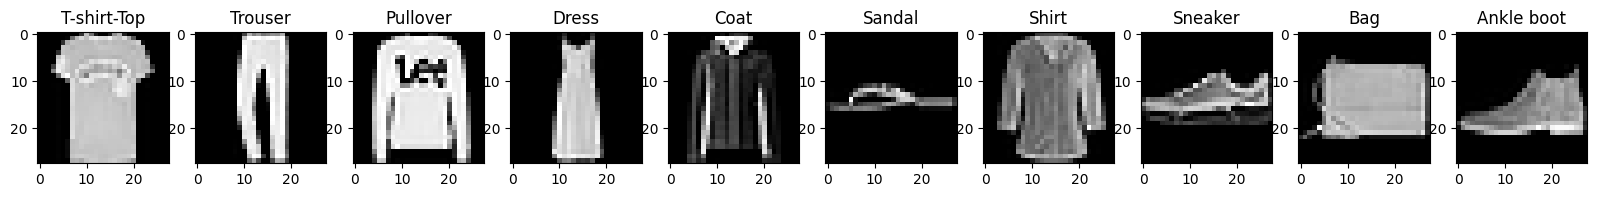

In [ ]:
labeldict = {
    0: 'T-shirt-Top',
    1: 'Trouser',
    2: 'Pullover',
    3: 'Dress',
    4: 'Coat',
    5: 'Sandal',
    6: 'Shirt',
    7: 'Sneaker',
    8: 'Bag',
    9: 'Ankle boot'
}

items_train = []
items_test = []

for i in range(10):
  items_train.append([])
  items_test.append([])
  for j in range(len(x_train)):
    if y_train[j]==i:
      items_train[i].append(x_train[j])
  for j in range(len(x_test)):
    if y_test[j]==i:
      items_test[i].append(x_test[j])

fig, ax = plt.subplots(1, 10, figsize=(20, 2))

# for i in range(10):
    # ax[i].imshow(x_train[i], cmap='gray')
    # ax[i].set_title(labeldict[y_train[i]])

for i in range(10):
    ax[i].imshow(items_test[i][0], cmap='gray')
    ax[i].set_title(labeldict[i])

In [ ]:
# Klasa która pozwala tworzyć autoenkoder o wybranym poziomie kompresji
class Conv2D_autoencoder:
    def __init__(self, x_train, x_test, y_train, y_test, name, cut_shape):
        self.x_train = x_train
        self.x_test = x_test
        self.y_train = y_train
        self.y_test = y_test
        self.name = name
        self.cut_shape = cut_shape
        self.input = Input(shape=(28, 28, 1))
        self.model, self.encoder, self.decoder = self.build_model(cut_shape)

    def build_model(self, cut_shape):
        #building encoder
        inputs = self.input
        inputs = Input(shape=(28, 28, 1))

        x = Conv2D(300, (3, 3), activation='relu', padding='same')(inputs)
        x = Conv2D(150, (3, 3), activation='relu', padding='same')(x)
        x = BatchNormalization()(x)
        x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
        x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
        x = BatchNormalization()(x)
        x = Conv2D(64, (2, 2), activation='relu', padding='same')(x)
        x = Conv2D(32, (2, 2), activation='relu', padding='same')(x)
        x = Flatten()(x)
        x = Dense(28*28, activation='relu')(x)
        x = BatchNormalization()(x)
        encoded = Dense(cut_shape, activation='relu')(x)

        encoder = Model(inputs=inputs, outputs=encoded)
        encoded_inputs = Input(shape=(cut_shape,))

        x = Dense(cut_shape, activation='relu')(encoded_inputs)
        x = Dense(28*28, activation='relu')(x)
        x = Reshape((28, 28, 1))(x)
        x = Conv2D(32, (2, 2), activation='relu', padding='same')(x)
        x = Conv2D(64, (2, 2), activation='relu', padding='same')(x)
        x = BatchNormalization()(x)
        x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
        x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
        x = BatchNormalization()(x)
        x = Conv2D(150, (3, 3), activation='relu', padding='same')(x)
        x = Conv2D(300, (3, 3), activation='relu', padding='same')(x)
        decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

        decoder = Model(inputs=encoded_inputs, outputs=decoded)

        def cmse(y_true, y_pred):
          local_diff = tf.abs(y_true - y_pred)
          num_pixels = tf.size(local_diff)
          num_pixels_to_consider = num_pixels // 2
          local_diff_flat = K.flatten(local_diff)
          threshold_diff, _ = tf.nn.top_k(local_diff_flat, k=num_pixels_to_consider, sorted=True)
          filtered_diff = tf.where(local_diff_flat >= threshold_diff[-1], local_diff_flat, tf.zeros_like(local_diff_flat))
          cmse = 2*K.mean(K.square(filtered_diff)) - tf.keras.metrics.mean_squared_error(y_true, y_pred)
          return cmse

        def psnr(y_true, y_pred):
          mse = tf.keras.metrics.mean_squared_error(y_true, y_pred)
          psnr = 10 * tf.experimental.numpy.log10(1.0 / tf.math.sqrt(mse))
          return psnr

        x = encoder(inputs)
        x = decoder(x)
        model = Model(inputs=inputs, outputs=x)
        model.compile(optimizer=optimizers.Adam(1e-3), loss='binary_crossentropy', metrics=['accuracy', 'mse', psnr, 'mae', cmse])

        print(model.summary())

        clr = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_delta=0.01,
        cooldown=0,
        min_lr=1e-7,
        verbose=1)

        model.fit(
            x_train,
            x_train,
            batch_size=256,
            epochs=30,
            shuffle=True,
            validation_data=(x_test, x_test),
            callbacks=[clr])

            # Zapisywanie modelu

        folder = os.path.join(folder_base, "Conv2D", str(cut_shape))

        print("Saving autoencoder")
        model_path = os.path.join(folder, "model.h5")
        model.save(model_path)

        print("Saving encoder")
        encoder_path = os.path.join(folder, "encoder.h5")
        encoder.save(encoder_path)

        print("Saving decoder")
        decoder_path = os.path.join(folder, "decoder.h5")
        decoder.save(decoder_path)

        history_path = os.path.join(folder, "history.csv")
        with open(history_path, mode='w') as file:
            writer = csv.writer(file)
            writer.writerow(["Epoch", "Loss", "Accuracy", "MSE", "VAL_MSE", "PSNR", "VAL_PSNR", "MAE", "VAL_MAE", "CMSE", "VAL_CMSE"])
            for i, loss in enumerate(model.history.history['loss']):
                epoch = i + 1
                acc = model.history.history['accuracy'][i]
                mse = model.history.history['mse'][i]
                val_mse = model.history.history['val_mse'][i]
                psnr = model.history.history['psnr'][i]
                val_psnr = model.history.history['val_psnr'][i]
                mae = model.history.history['mae'][i]
                val_mae = model.history.history['val_mae'][i]
                cmse = model.history.history['cmse'][i]
                val_cmse = model.history.history['val_cmse'][i]
                writer.writerow([epoch, loss, acc, mse, val_mse, psnr, val_psnr, mae, val_mae, cmse, val_cmse])

        return model, encoder, decoder

    def plot_image_reconstructions(self, all_index, items_per_category):
        # Wyświetlanie obrazów i macierzy liczbowych
        fig, axs = plt.subplots(2, 10 * items_per_category, figsize=(30 * items_per_category/2, 6))
        all_encoded = []
        mse_values = []
        psnr_values = []
        # Wyświetlanie obrazu przed enkoderem
        for i in range(10):
            for j in range(items_per_category):
              # Przekształcanie obrazu przez modele enkodera i dekodera
              input_image = items_test[i][all_index[i][0][j]]
              encoded_image = self.encoder.predict(np.expand_dims(input_image, axis=0))
              decoded_image = self.decoder.predict(encoded_image)

              # Pobieranie rozmiarów skompresowanych obrazów
              input_shape = input_image.shape[:2]
              encoded_shape = encoded_image.shape

              fig.suptitle(f'Conv2D autoencoder - {self.cut_shape}', fontsize=16)

              # Wyświetlanie obrazu po dekoderze
              axs[0, i * items_per_category + j].imshow(input_image, cmap='gray')
              axs[0, i * items_per_category + j].set_title(labeldict[i])
              axs[0, i * items_per_category + j].axis('off')

              # Wyświetlanie obrazu po dekoderze
              axs[1, i * items_per_category + j].imshow(decoded_image.squeeze(), cmap='gray')
              axs[1, i * items_per_category + j].axis('off')

              all_encoded.append([encoded_image, i, j])
              mse = mean_squared_error(input_image, decoded_image.squeeze())
              psnr = 10 * math.log10(1. / math.sqrt(mse))
              mse_values.append(mse)
              psnr_values.append(psnr)

        plt.tight_layout()
        plt.show()

        folder = os.path.join(folder_base, "Dense", str(self.cut_shape), "Encoded")

        print("Encoded output")
        for i in range(len(all_encoded)) :
          print(f"Image {i+1} before decoder:")
          print(f"MSE: {mse_values[i]}")
          print(f"PSNR: {psnr_values[i]}")

          encoded_path = os.path.join(folder, labeldict[all_encoded[i][1]] + str(all_encoded[i][2]) + ".txt")
          os.makedirs(os.path.dirname(encoded_path), exist_ok=True)
          with open(encoded_path, mode='w') as file:
              file.write(str(all_encoded[i][0]))

    def apply_autoencoder(self, dataset):
        encoded_dataset = self.encoder.predict(dataset)
        decoded_dataset = self.decoder.predict(encoded_dataset)
        return decoded_dataset



Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 model (Functional)          (None, 3)                 20446097  
                                                                 
 model_1 (Functional)        (None, 28, 28, 1)         814723    
                                                                 
Total params: 21,260,820
Trainable params: 21,258,312
Non-trainable params: 2,508
_________________________________________________________________
None
Epoch 1/30
235/235 [==============================] - 113s 396ms/step - loss: 0.3997 - accuracy: 0.4895 - mse: 0.0525 - psnr: 9.0357 - mae: 0.1542 - cmse: 0.0485 - val_loss: 0.6123 - val_accuracy: 0.4999 - val_mse: 0.1301 - val_psnr: 5.3824 - val_mae: 0.2768 - val_cmse: 0.1176 - lr: 0.0010
Epoch 2/30


Saving encoder


Saving decoder
1/1 [==============================] - 0s 21ms/step


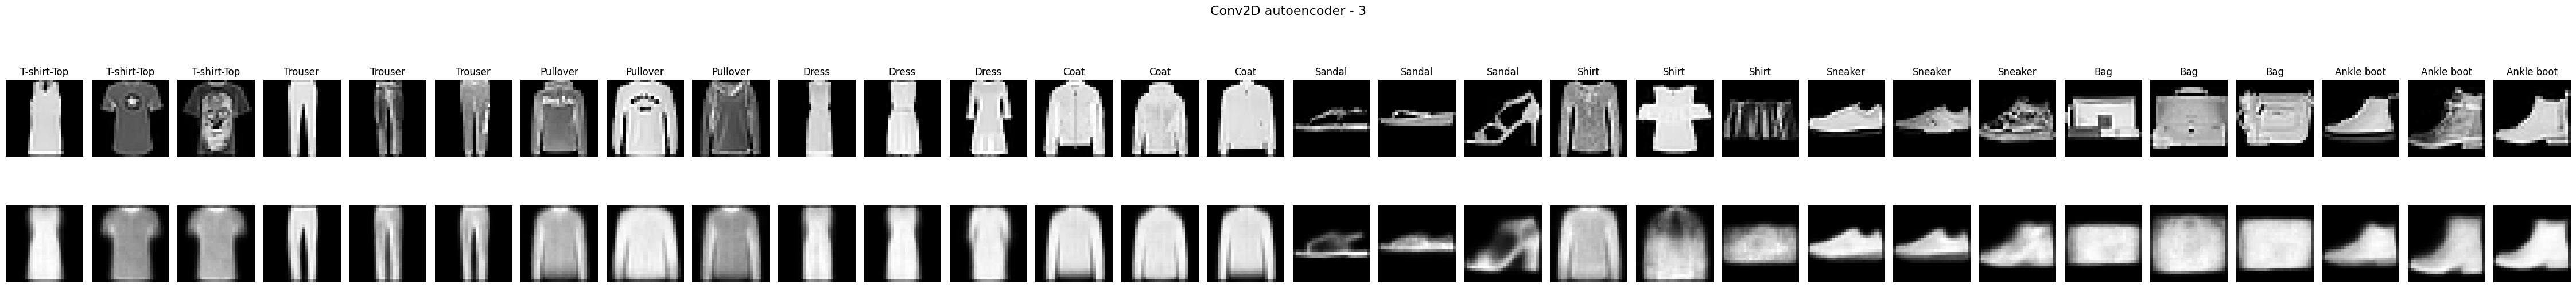

Encoded output
Image 1 before decoder:
MSE: 0.017871045010564076
PSNR: 8.739250256763324
Image 2 before decoder:
MSE: 0.007743960362199839
PSNR: 10.555184393246469
Image 3 before decoder:
MSE: 0.02740633787753387
PSNR: 7.810744962002284
Image 4 before decoder:
MSE: 0.007851620357205187
PSNR: 10.525203538200765
Image 5 before decoder:
MSE: 0.009288100757771535
PSNR: 10.160365409980683
Image 6 before decoder:
MSE: 0.016880593814864366
PSNR: 8.863061400523721
Image 7 before decoder:
MSE: 0.015812342658750568
PSNR: 9.00501891460255
Image 8 before decoder:
MSE: 0.0453068784056474
PSNR: 6.719179296023495
Image 9 before decoder:
MSE: 0.017138793833656667
PSNR: 8.830098727063934
Image 10 before decoder:
MSE: 0.026047551058547353
PSNR: 7.921165509951814
Image 11 before decoder:
MSE: 0.012923142179832718
PSNR: 9.44315938780052
Image 12 before decoder:
MSE: 0.023428205516267543
PSNR: 8.151304874605598
Image 13 before decoder:
MSE: 0.026804077285030207
PSNR: 7.85899569259761
Image 14 before decode

Saving encoder


Saving decoder
1/1 [==============================] - 0s 25ms/step


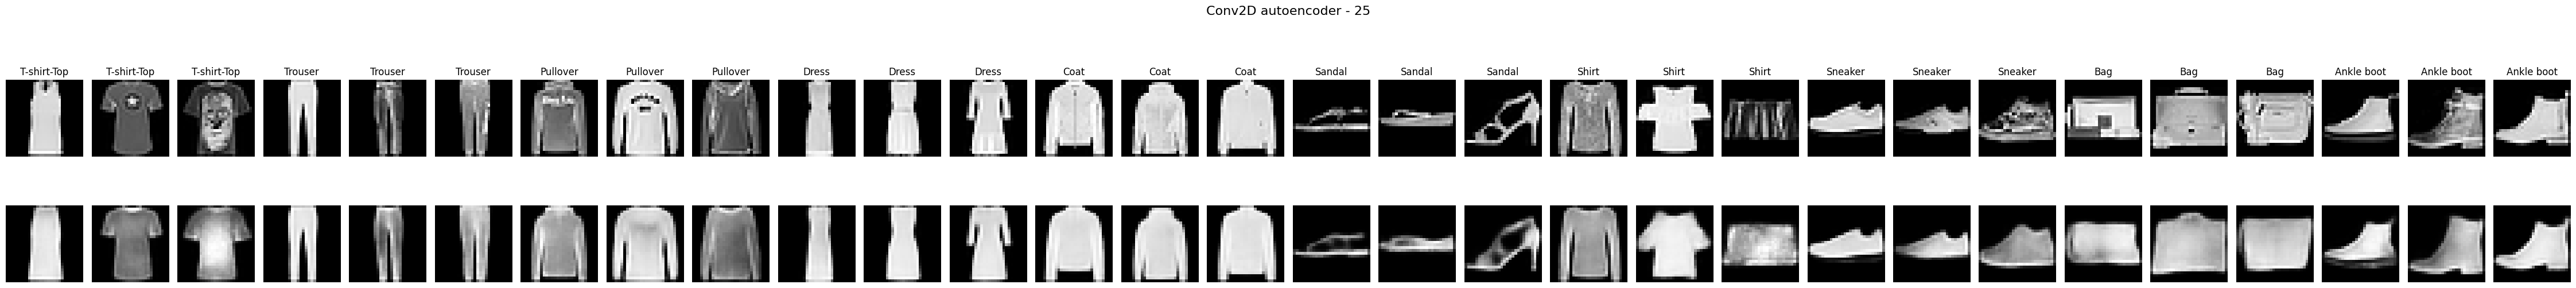

Encoded output
Image 1 before decoder:
MSE: 0.0039230050564255225
PSNR: 12.031905660504133
Image 2 before decoder:
MSE: 0.0045687097105657605
PSNR: 11.701032177662547
Image 3 before decoder:
MSE: 0.019292785317808262
PSNR: 8.573025341606591
Image 4 before decoder:
MSE: 0.0010012532439378345
PSNR: 14.997280319222579
Image 5 before decoder:
MSE: 0.0038689878604163132
PSNR: 12.062013164733758
Image 6 before decoder:
MSE: 0.0035929641449840575
PSNR: 12.22273558349146
Image 7 before decoder:
MSE: 0.007867958026876239
PSNR: 10.520689827866619
Image 8 before decoder:
MSE: 0.015332461650280458
PSNR: 9.07194056450592
Image 9 before decoder:
MSE: 0.008569639998768485
PSNR: 10.335187109656037
Image 10 before decoder:
MSE: 0.0032593992514498753
PSNR: 12.43431219263976
Image 11 before decoder:
MSE: 0.0014069300017589674
PSNR: 14.258637546252157
Image 12 before decoder:
MSE: 0.0033603848201691207
PSNR: 12.368054928964035
Image 13 before decoder:
MSE: 0.0037369266500229302
PSNR: 12.137427132912535
Im

Saving encoder


Saving decoder
1/1 [==============================] - 0s 24ms/step


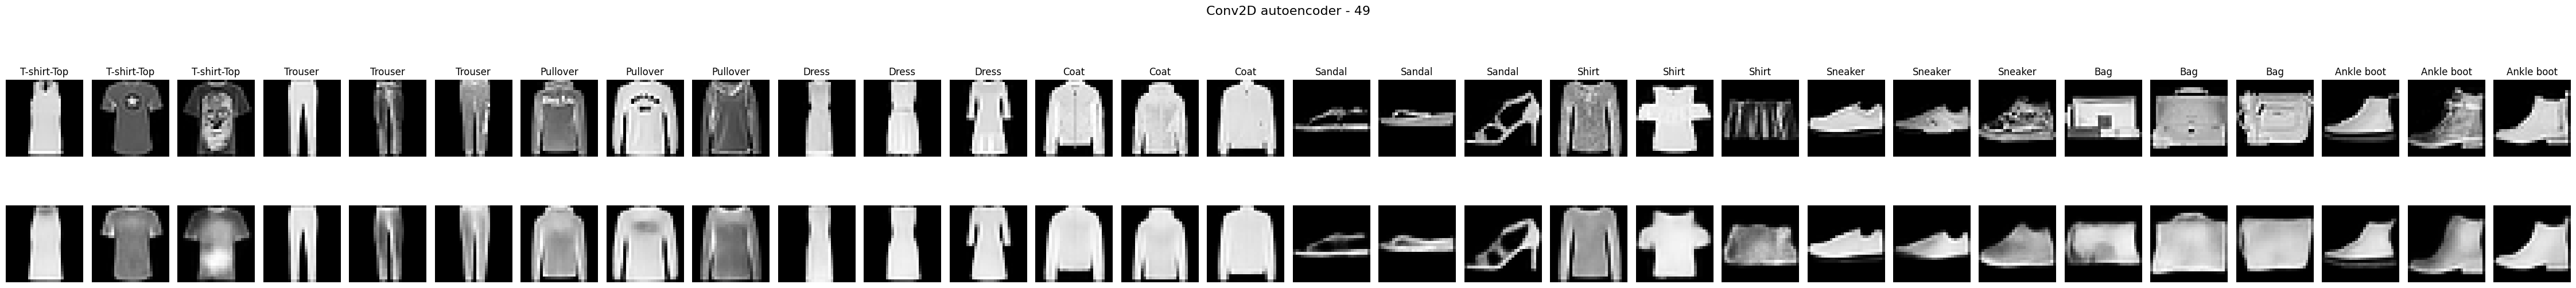

Encoded output
Image 1 before decoder:
MSE: 0.002952454734758792
PSNR: 12.64908376001199
Image 2 before decoder:
MSE: 0.004099239686557679
PSNR: 11.93648343658769
Image 3 before decoder:
MSE: 0.014219922067648409
PSNR: 9.235513918763683
Image 4 before decoder:
MSE: 0.000712723353386256
PSNR: 15.735395053492287
Image 5 before decoder:
MSE: 0.002554571738534054
PSNR: 12.96340948387118
Image 6 before decoder:
MSE: 0.003181403265287898
PSNR: 12.486906387583343
Image 7 before decoder:
MSE: 0.0063693997456846785
PSNR: 10.979507468951283
Image 8 before decoder:
MSE: 0.013778132622082485
PSNR: 9.304048196205972
Image 9 before decoder:
MSE: 0.006357974119167939
PSNR: 10.983406221305215
Image 10 before decoder:
MSE: 0.002082258737123318
PSNR: 13.407326534734237
Image 11 before decoder:
MSE: 0.0011862424252617359
PSNR: 14.629132738692729
Image 12 before decoder:
MSE: 0.0023711171749380665
PSNR: 13.125234918486102
Image 13 before decoder:
MSE: 0.002829619256821209
PSNR: 12.741359988077896
Image 14

Saving encoder


Saving decoder
1/1 [==============================] - 0s 23ms/step


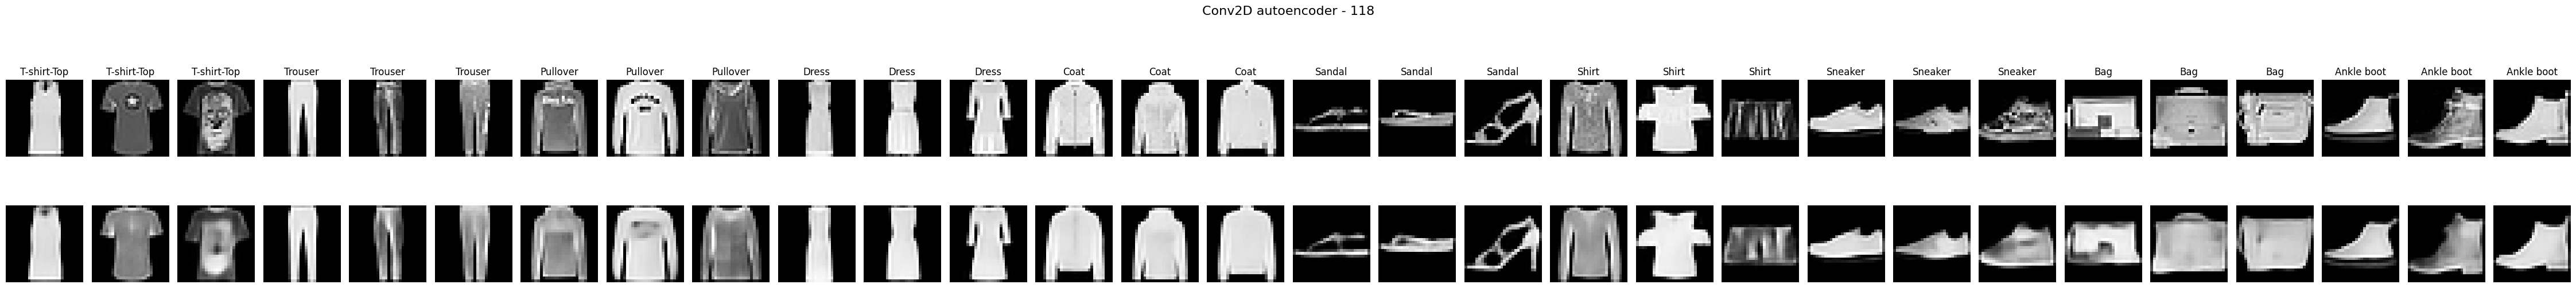

Encoded output
Image 1 before decoder:
MSE: 0.0014037898487487103
PSNR: 14.26348951217053
Image 2 before decoder:
MSE: 0.003430379752053302
PSNR: 12.323288998777212
Image 3 before decoder:
MSE: 0.007965907871072061
PSNR: 10.49382360343988
Image 4 before decoder:
MSE: 0.0004017335318890493
PSNR: 16.980309585347058
Image 5 before decoder:
MSE: 0.002163123543784303
PSNR: 13.324593378644652
Image 6 before decoder:
MSE: 0.0018401803886224609
PSNR: 13.67569801010619
Image 7 before decoder:
MSE: 0.005137866064497454
PSNR: 11.446086106233771
Image 8 before decoder:
MSE: 0.009428762365820898
PSNR: 10.127726548492282
Image 9 before decoder:
MSE: 0.005206262651694672
PSNR: 11.417369629362605
Image 10 before decoder:
MSE: 0.0011864188309113686
PSNR: 14.628809843883563
Image 11 before decoder:
MSE: 0.0009803796478949712
PSNR: 15.043028565122302
Image 12 before decoder:
MSE: 0.0017500607712478118
PSNR: 13.784734350399006
Image 13 before decoder:
MSE: 0.0019252595793845663
PSNR: 13.577553535208223
Im

In [ ]:
# Tworzenie obiektów dla różnych wartości compression_level
conv_2d = [3, 25, 49, 118]
autoencoders = []

# Wybieranie losowych indeksów obrazów testowych - po 2 dla każdej klasy
num_samples = 3
all_indexes = []
for i in range(10):
  all_indexes.append([])
  all_indexes[i].append(random.sample(range(len(items_test[i])), num_samples))


for cut in conv_2d:
    autoencoder = Conv2D_autoencoder(x_train, x_test, y_train, y_test, f"Conv2D_autoencoder_{cut}", cut)
    autoencoder.plot_image_reconstructions(all_indexes, num_samples)
    autoencoders.append(autoencoder)
